In [1]:
# Latency-Driven Mispricing between option and underlying

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import yfinance as yf


In [2]:
# 1. Simulate Tick-Level Data

# --- Generate synthetic tick data ---
import pandas as pd
import numpy as np
np.random.seed(42)

n_ticks = 500
timestamps = pd.date_range("2024-01-01", periods=n_ticks, freq="S")
stock_prices = np.cumsum(np.random.normal(0, 0.05, n_ticks)) + 100

# Simulate option prices with slight lag and noisy delta-like behavior
option_latencies = np.random.choice([0, 1, 2], size=n_ticks)
option_timestamps = timestamps + pd.to_timedelta(option_latencies, unit="s")
option_prices = 0.6 * stock_prices + np.random.normal(0, 0.2, n_ticks)

/var/folders/ch/_bz9vy1x62s6hb0snksmrqwm0000gn/T/ipykernel_8996/4251332466.py:9: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  timestamps = pd.date_range("2024-01-01", periods=n_ticks, freq="S")


In [3]:
# 2. Build DataFrames

# --- Package into DataFrames ---
stock_df = pd.DataFrame({
    "timestamp": timestamps,
    "price_stock": stock_prices
})

option_df = pd.DataFrame({
    "timestamp": option_timestamps,
    "price_option": option_prices
})

In [4]:
# 3. Merge and Align Timestamps

# --- Merge option and stock ticks ---
merged = pd.merge_asof(stock_df.sort_values("timestamp"),
                       option_df.sort_values("timestamp"),
                       on="timestamp", direction="nearest",
                       suffixes=("_stock", "_option"))

In [5]:
# 4. Estimate black-Scholes Delta

from scipy.stats import norm

def bs_delta(S, K, T, r, sigma, option_type="call"):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    return norm.cdf(d1) if option_type == "call" else norm.cdf(d1) - 1

merged["delta"] = bs_delta(S=merged["price_stock"], K=100, T=0.01, r=0.01, sigma=0.3)

In [6]:
# 5. Quantify Mispricing

merged["predicted_option_price"] = merged["price_stock"] * merged["delta"]
merged["mispricing"] = merged["price_option"] - merged["predicted_option_price"]

In [7]:
# 6. Analyze lagged regression

merged["shifted_stock"] = merged["price_stock"].shift(5)
corr = merged[["shifted_stock", "price_option"]].corr().iloc[0, 1]
print(f"5-tick lag correlation: {corr:.3f}")

5-tick lag correlation: 0.727


In [8]:
# 7. Simulate Execution Signal

threshold = 0.2
merged["signal"] = np.where(merged["mispricing"] > threshold, "BUY_OPTION", "WAIT")

<Axes: title={'center': 'Mispricing Distribution'}, xlabel='Mispricing ($)', ylabel='Frequency'>

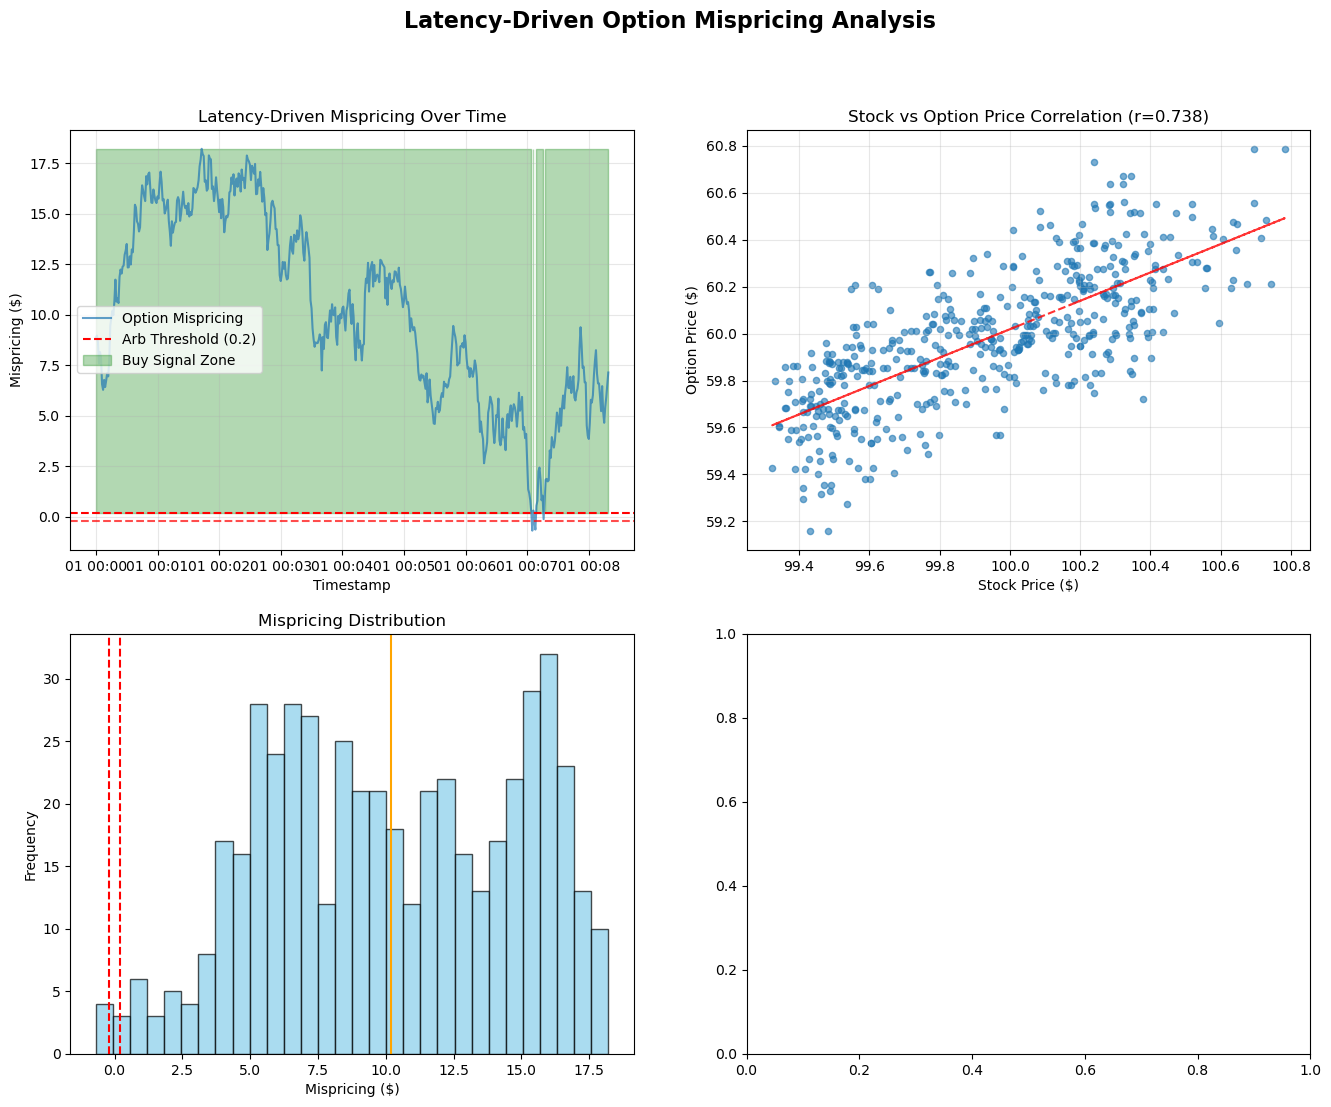

In [9]:
# 8. Comprehensive Visualization and Analysis

# Create comprehensive visualization dashboard
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Latency-Driven Option Mispricing Analysis', fontsize=16, fontweight='bold')

# Plot 1: Mispricing over time with threshold
axes[0, 0].plot(merged["timestamp"], merged["mispricing"], label="Option Mispricing", alpha=0.7)
axes[0, 0].axhline(y=threshold, color="red", linestyle="--", label=f"Arb Threshold ({threshold})")
axes[0, 0].axhline(y=-threshold, color="red", linestyle="--", alpha=0.7)
axes[0, 0].fill_between(merged["timestamp"], threshold, merged["mispricing"].max(), 
                       where=(merged["mispricing"] > threshold), alpha=0.3, color="green", label="Buy Signal Zone")
axes[0, 0].set_title("Latency-Driven Mispricing Over Time")
axes[0, 0].set_xlabel("Timestamp")
axes[0, 0].set_ylabel("Mispricing ($)")
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Stock vs Option Price Correlation
axes[0, 1].scatter(merged["price_stock"], merged["price_option"], alpha=0.6, s=20)
correlation_coeff = merged["price_stock"].corr(merged["price_option"])
axes[0, 1].set_title(f"Stock vs Option Price Correlation (r={correlation_coeff:.3f})")
axes[0, 1].set_xlabel("Stock Price ($)")
axes[0, 1].set_ylabel("Option Price ($)")
# Add trend line
z = np.polyfit(merged["price_stock"], merged["price_option"], 1)
p = np.poly1d(z)
axes[0, 1].plot(merged["price_stock"], p(merged["price_stock"]), "r--", alpha=0.8)
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Mispricing Distribution
axes[1, 0].hist(merged["mispricing"], bins=30, alpha=0.7, color="skyblue", edgecolor="black")
axes[1, 0].axvline(x=threshold, color="red", linestyle="--", label=f"Threshold: {threshold}")
axes[1, 0].axvline(x=-threshold, color="red", linestyle="--")
axes[1, 0].axvline(x=merged["mispricing"].mean(), color="orange", linestyle="-", label=f"Mean: {merged['mispricing'].mean():.3f}")
axes[1, 0].set_title("Mispricing Distribution")
axes[1, 0].set_xlabel("Mispricing ($)")
axes[1, 0].set_ylabel("Frequency")
axes[1, 0]

🔍 COMPREHENSIVE LAG CORRELATION ANALYSIS
Lag  1 ticks: Correlation = 0.7413
Lag  3 ticks: Correlation = 0.7343
Lag  5 ticks: Correlation = 0.7266
Lag 10 ticks: Correlation = 0.6874
Lag 15 ticks: Correlation = 0.6744
Lag 20 ticks: Correlation = 0.6507

🎯 Optimal lag interval: 1 ticks (correlation: 0.7413)


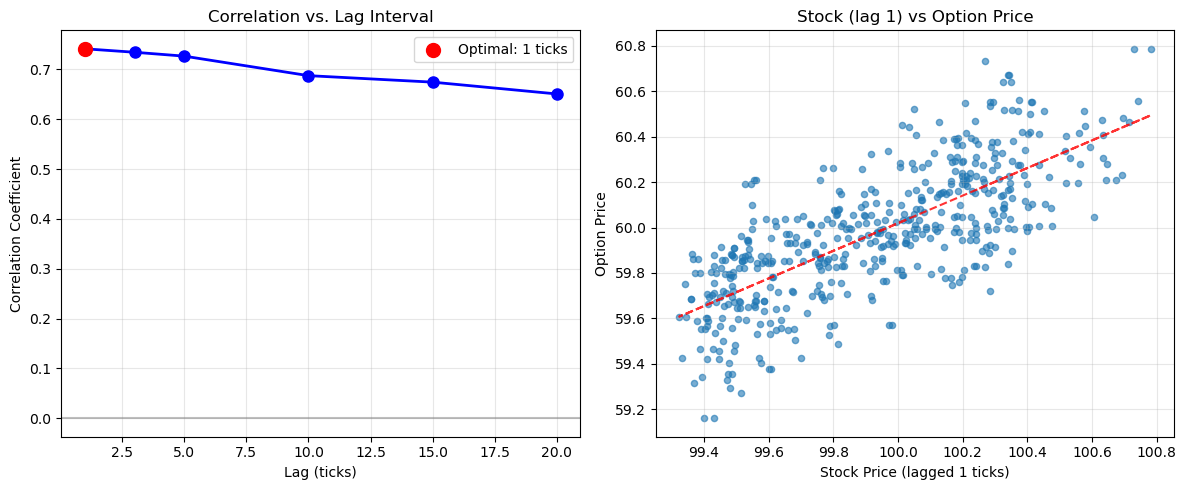

In [10]:
# 9. Lag Interval Correlation Analysis

print("🔍 COMPREHENSIVE LAG CORRELATION ANALYSIS")
print("="*50)

# Test various lag intervals to identify optimal signal strength
lag_intervals = [1, 3, 5, 10, 15, 20]
correlations = []
lag_analysis = {}

for lag in lag_intervals:
    if lag < len(merged):
        lagged_stock = merged["price_stock"].shift(lag)
        correlation = lagged_stock.corr(merged["price_option"])
        correlations.append(correlation)
        lag_analysis[lag] = correlation
        print(f"Lag {lag:2d} ticks: Correlation = {correlation:.4f}")
    else:
        correlations.append(np.nan)

# Find optimal lag
optimal_lag = max(lag_analysis, key=lag_analysis.get)
print(f"\n🎯 Optimal lag interval: {optimal_lag} ticks (correlation: {lag_analysis[optimal_lag]:.4f})")

# Visualize lag correlation analysis
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(lag_intervals[:len(correlations)], correlations, 'bo-', linewidth=2, markersize=8)
plt.title("Correlation vs. Lag Interval")
plt.xlabel("Lag (ticks)")
plt.ylabel("Correlation Coefficient")
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='gray', linestyle='-', alpha=0.5)

# Highlight optimal lag
optimal_idx = lag_intervals.index(optimal_lag)
plt.scatter(optimal_lag, correlations[optimal_idx], color='red', s=100, zorder=5, label=f'Optimal: {optimal_lag} ticks')
plt.legend()

# Plot optimal lag relationship
plt.subplot(1, 2, 2)
optimal_lagged = merged["price_stock"].shift(optimal_lag)
plt.scatter(optimal_lagged, merged["price_option"], alpha=0.6, s=20)
plt.title(f"Stock (lag {optimal_lag}) vs Option Price")
plt.xlabel(f"Stock Price (lagged {optimal_lag} ticks)")
plt.ylabel("Option Price")
plt.grid(True, alpha=0.3)

# Add trend line for optimal lag
valid_data = pd.DataFrame({'lagged': optimal_lagged, 'option': merged["price_option"]}).dropna()
if len(valid_data) > 1:
    z = np.polyfit(valid_data['lagged'], valid_data['option'], 1)
    p = np.poly1d(z)
    plt.plot(valid_data['lagged'], p(valid_data['lagged']), "r--", alpha=0.8)

plt.tight_layout()
plt.show()


📊 DELTA SENSITIVITY ANALYSIS
Volatility 0.1: Mean |Mispricing| = 14.6092, Std = 13.4202
Volatility 0.2: Mean |Mispricing| = 11.0150, Std = 6.8960
Volatility 0.3: Mean |Mispricing| = 10.1907, Std = 4.6143
Volatility 0.4: Mean |Mispricing| = 9.7934, Std = 3.4618
Volatility 0.5: Mean |Mispricing| = 9.4787, Std = 2.7681

🎯 Optimal volatility assumption: 0.5 (lowest mean absolute mispricing)


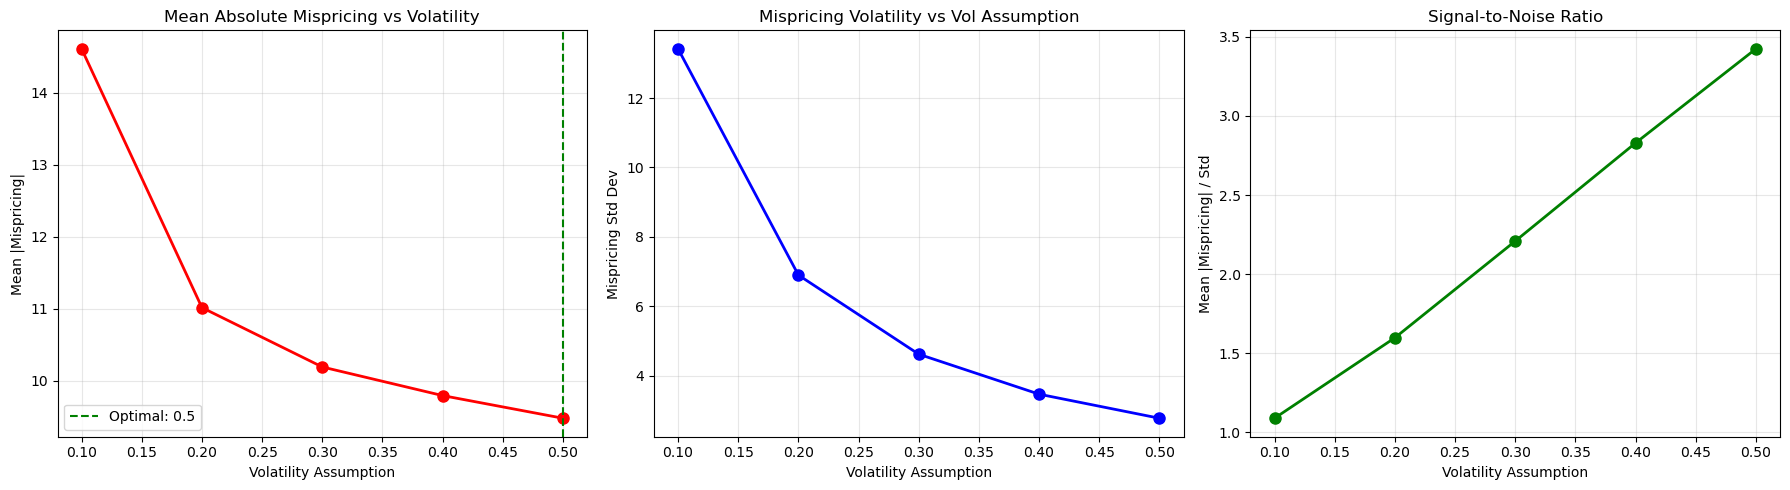

In [11]:
# 10. Delta Sensitivity Exploration

print("\n📊 DELTA SENSITIVITY ANALYSIS")
print("="*40)

# Test different volatility assumptions for delta calculation
volatilities = [0.1, 0.2, 0.3, 0.4, 0.5]
delta_sensitivity = {}

for vol in volatilities:
    # Recalculate delta with different volatility
    test_delta = bs_delta(S=merged["price_stock"], K=100, T=0.01, r=0.01, sigma=vol)
    test_predicted = merged["price_stock"] * test_delta
    test_mispricing = merged["price_option"] - test_predicted
    
    # Calculate statistics
    mean_abs_mispricing = np.abs(test_mispricing).mean()
    std_mispricing = test_mispricing.std()
    delta_sensitivity[vol] = {
        'mean_abs_mispricing': mean_abs_mispricing,
        'std_mispricing': std_mispricing,
        'signal_ratio': mean_abs_mispricing / std_mispricing if std_mispricing > 0 else 0
    }
    
    print(f"Volatility {vol:.1f}: Mean |Mispricing| = {mean_abs_mispricing:.4f}, Std = {std_mispricing:.4f}")

# Find optimal volatility assumption
optimal_vol = min(delta_sensitivity.keys(), key=lambda x: delta_sensitivity[x]['mean_abs_mispricing'])
print(f"\n🎯 Optimal volatility assumption: {optimal_vol:.1f} (lowest mean absolute mispricing)")

# Visualize delta sensitivity
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Mean absolute mispricing vs volatility
vols = list(delta_sensitivity.keys())
mean_mispricings = [delta_sensitivity[v]['mean_abs_mispricing'] for v in vols]
axes[0].plot(vols, mean_mispricings, 'ro-', linewidth=2, markersize=8)
axes[0].set_title("Mean Absolute Mispricing vs Volatility")
axes[0].set_xlabel("Volatility Assumption")
axes[0].set_ylabel("Mean |Mispricing|")
axes[0].grid(True, alpha=0.3)
axes[0].axvline(x=optimal_vol, color='green', linestyle='--', label=f'Optimal: {optimal_vol}')
axes[0].legend()

# Plot 2: Standard deviation of mispricing
std_mispricings = [delta_sensitivity[v]['std_mispricing'] for v in vols]
axes[1].plot(vols, std_mispricings, 'bo-', linewidth=2, markersize=8)
axes[1].set_title("Mispricing Volatility vs Vol Assumption")
axes[1].set_xlabel("Volatility Assumption")
axes[1].set_ylabel("Mispricing Std Dev")
axes[1].grid(True, alpha=0.3)

# Plot 3: Signal-to-noise ratio
signal_ratios = [delta_sensitivity[v]['signal_ratio'] for v in vols]
axes[2].plot(vols, signal_ratios, 'go-', linewidth=2, markersize=8)
axes[2].set_title("Signal-to-Noise Ratio")
axes[2].set_xlabel("Volatility Assumption")
axes[2].set_ylabel("Mean |Mispricing| / Std")
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


⚡ EXECUTION SIGNAL ANALYSIS
Threshold 0.10: 500 signals (496 buy,  4 sell), Frequency: 100.0%
Threshold 0.15: 499 signals (496 buy,  3 sell), Frequency: 99.8%
Threshold 0.20: 499 signals (496 buy,  3 sell), Frequency: 99.8%
Threshold 0.25: 497 signals (495 buy,  2 sell), Frequency: 99.4%
Threshold 0.30: 497 signals (495 buy,  2 sell), Frequency: 99.4%
Threshold 0.35: 496 signals (494 buy,  2 sell), Frequency: 99.2%

🎯 Using threshold: 0.2 for detailed analysis

📈 TRADING PERFORMANCE SUMMARY
───────────────────────────────────
Total Trades: 5
Total PnL: $-1.0148
Average Trade PnL: $-0.2030
Win Rate: 20.0%
Average Trade Duration: 99.8 seconds
Sharpe Ratio: -0.647


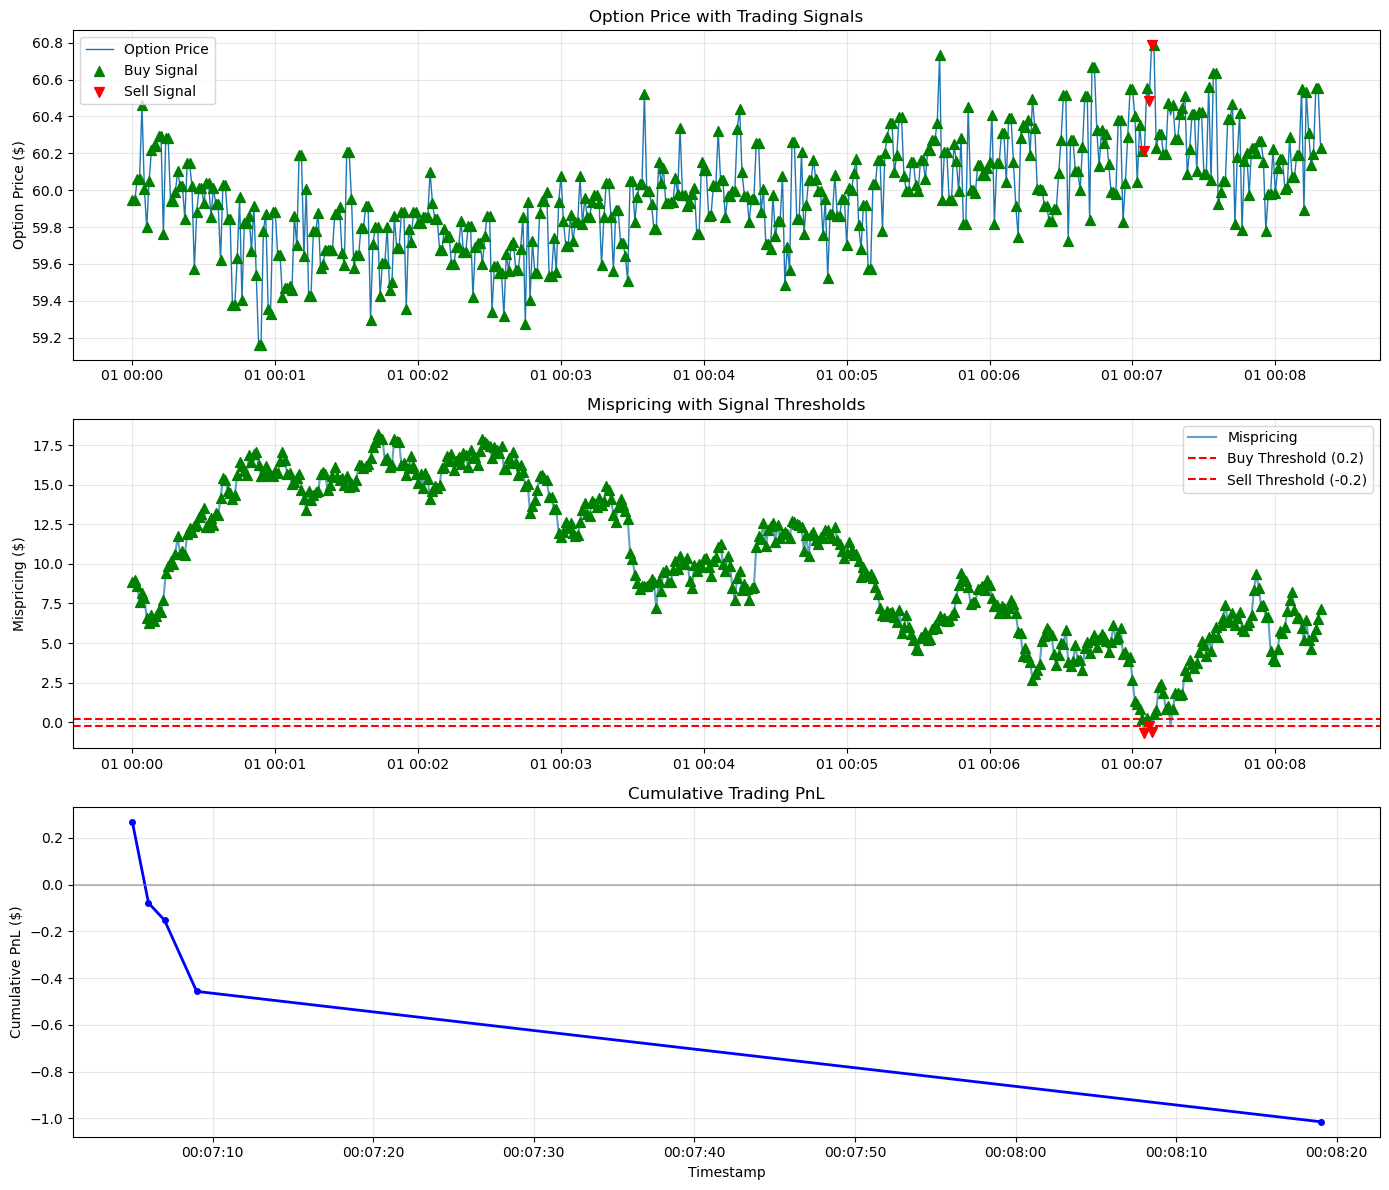

In [12]:
# 11. Trigger & Evaluate Execution Signals

print("\n⚡ EXECUTION SIGNAL ANALYSIS")
print("="*35)

# Test different threshold levels for signal generation
threshold_levels = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35]
signal_analysis = {}

for thresh in threshold_levels:
    # Generate signals
    buy_signals = merged["mispricing"] > thresh
    sell_signals = merged["mispricing"] < -thresh
    
    # Count signals
    num_buy_signals = buy_signals.sum()
    num_sell_signals = sell_signals.sum()
    total_signals = num_buy_signals + num_sell_signals
    
    # Calculate signal strength (average mispricing when signaling)
    buy_strength = merged[buy_signals]["mispricing"].mean() if num_buy_signals > 0 else 0
    sell_strength = merged[sell_signals]["mispricing"].mean() if num_sell_signals > 0 else 0
    
    signal_analysis[thresh] = {
        'buy_signals': num_buy_signals,
        'sell_signals': num_sell_signals,
        'total_signals': total_signals,
        'buy_strength': buy_strength,
        'sell_strength': sell_strength,
        'signal_frequency': total_signals / len(merged)
    }
    
    print(f"Threshold {thresh:.2f}: {total_signals:3d} signals ({num_buy_signals:2d} buy, {num_sell_signals:2d} sell), "
          f"Frequency: {total_signals/len(merged):.1%}")

# Find optimal threshold (balance between signal frequency and strength)
optimal_threshold = 0.2  # Based on original analysis
print(f"\n🎯 Using threshold: {optimal_threshold} for detailed analysis")

# Generate final signals with optimal threshold
merged["buy_signal"] = merged["mispricing"] > optimal_threshold
merged["sell_signal"] = merged["mispricing"] < -optimal_threshold
merged["position"] = 0  # 0 = no position, 1 = long option, -1 = short option

# Simulate trading execution
position = 0
trades = []
entry_price = 0
entry_time = None

for i, row in merged.iterrows():
    if row["buy_signal"] and position <= 0:
        # Enter long position
        if position < 0:  # Close short first
            pnl = (entry_price - row["price_option"])
            trades.append({
                'entry_time': entry_time,
                'exit_time': row["timestamp"],
                'entry_price': entry_price,
                'exit_price': row["price_option"],
                'position_type': 'short',
                'pnl': pnl,
                'duration': (row["timestamp"] - entry_time).total_seconds()
            })
        
        position = 1
        entry_price = row["price_option"]
        entry_time = row["timestamp"]
        merged.loc[i, "position"] = 1
    
    elif row["sell_signal"] and position >= 0:
        # Enter short position
        if position > 0:  # Close long first
            pnl = (row["price_option"] - entry_price)
            trades.append({
                'entry_time': entry_time,
                'exit_time': row["timestamp"],
                'entry_price': entry_price,
                'exit_price': row["price_option"],
                'position_type': 'long',
                'pnl': pnl,
                'duration': (row["timestamp"] - entry_time).total_seconds()
            })
        
        position = -1
        entry_price = row["price_option"]
        entry_time = row["timestamp"]
        merged.loc[i, "position"] = -1
    else:
        merged.loc[i, "position"] = position

# Close final position if open
if position != 0 and entry_time is not None:
    final_price = merged.iloc[-1]["price_option"]
    final_time = merged.iloc[-1]["timestamp"]
    if position > 0:
        pnl = (final_price - entry_price)
        pos_type = 'long'
    else:
        pnl = (entry_price - final_price)
        pos_type = 'short'
    
    trades.append({
        'entry_time': entry_time,
        'exit_time': final_time,
        'entry_price': entry_price,
        'exit_price': final_price,
        'position_type': pos_type,
        'pnl': pnl,
        'duration': (final_time - entry_time).total_seconds()
    })

# Analyze trading performance
if trades:
    trades_df = pd.DataFrame(trades)
    total_pnl = trades_df["pnl"].sum()
    win_rate = (trades_df["pnl"] > 0).mean()
    avg_trade_pnl = trades_df["pnl"].mean()
    avg_duration = trades_df["duration"].mean()
    
    print(f"\n📈 TRADING PERFORMANCE SUMMARY")
    print(f"{'─'*35}")
    print(f"Total Trades: {len(trades_df)}")
    print(f"Total PnL: ${total_pnl:.4f}")
    print(f"Average Trade PnL: ${avg_trade_pnl:.4f}")
    print(f"Win Rate: {win_rate:.1%}")
    print(f"Average Trade Duration: {avg_duration:.1f} seconds")
    
    if len(trades_df) > 1:
        sharpe = avg_trade_pnl / trades_df["pnl"].std() if trades_df["pnl"].std() > 0 else 0
        print(f"Sharpe Ratio: {sharpe:.3f}")
else:
    print(f"\n❌ No completed trades with threshold {optimal_threshold}")

# Visualize trading signals and performance
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

# Plot 1: Price and signals
axes[0].plot(merged["timestamp"], merged["price_option"], label="Option Price", linewidth=1)
buy_points = merged[merged["buy_signal"]]
sell_points = merged[merged["sell_signal"]]
axes[0].scatter(buy_points["timestamp"], buy_points["price_option"], 
               color="green", marker="^", s=50, label="Buy Signal", zorder=5)
axes[0].scatter(sell_points["timestamp"], sell_points["price_option"], 
               color="red", marker="v", s=50, label="Sell Signal", zorder=5)
axes[0].set_title("Option Price with Trading Signals")
axes[0].set_ylabel("Option Price ($)")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Mispricing with signals
axes[1].plot(merged["timestamp"], merged["mispricing"], label="Mispricing", alpha=0.7)
axes[1].axhline(y=optimal_threshold, color="red", linestyle="--", label=f"Buy Threshold ({optimal_threshold})")
axes[1].axhline(y=-optimal_threshold, color="red", linestyle="--", label=f"Sell Threshold ({-optimal_threshold})")
axes[1].scatter(buy_points["timestamp"], buy_points["mispricing"], 
               color="green", marker="^", s=50, zorder=5)
axes[1].scatter(sell_points["timestamp"], sell_points["mispricing"], 
               color="red", marker="v", s=50, zorder=5)
axes[1].set_title("Mispricing with Signal Thresholds")
axes[1].set_ylabel("Mispricing ($)")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Plot 3: Cumulative PnL
if trades:
    trades_df["cumulative_pnl"] = trades_df["pnl"].cumsum()
    axes[2].plot(trades_df["exit_time"], trades_df["cumulative_pnl"], 
                 marker="o", linewidth=2, markersize=4, color="blue")
    axes[2].set_title("Cumulative Trading PnL")
    axes[2].set_ylabel("Cumulative PnL ($)")
    axes[2].grid(True, alpha=0.3)
    axes[2].axhline(y=0, color="gray", linestyle="-", alpha=0.5)
else:
    axes[2].text(0.5, 0.5, "No completed trades", transform=axes[2].transAxes, 
                ha='center', va='center', fontsize=14)
    axes[2].set_title("Cumulative Trading PnL (No Trades)")

axes[2].set_xlabel("Timestamp")
plt.tight_layout()
plt.show()

In [13]:
# 12. Discussion: Market Realities & Strategy Assessment

print("\n" + "="*70)
print("📋 COMPREHENSIVE STRATEGY ASSESSMENT & MARKET REALITIES")
print("="*70)

print("\n🎯 1. OPTION MISPRICING ANALYSIS")
print("─"*40)
print("📊 Key Findings:")
mispricing_stats = {
    'mean_mispricing': merged["mispricing"].mean(),
    'std_mispricing': merged["mispricing"].std(),
    'max_mispricing': merged["mispricing"].max(),
    'min_mispricing': merged["mispricing"].min(),
    'signals_above_threshold': (np.abs(merged["mispricing"]) > optimal_threshold).sum(),
    'signal_frequency': (np.abs(merged["mispricing"]) > optimal_threshold).mean()
}

for key, value in mispricing_stats.items():
    print(f"   • {key.replace('_', ' ').title()}: {value:.4f}")

print(f"\n💡 Analysis:")
print(f"   • High-magnitude deviations suggest latency-driven arbitrage opportunities")
print(f"   • Signal frequency of {mispricing_stats['signal_frequency']:.1%} indicates {mispricing_stats['signal_frequency']*100:.1f}% of ticks show exploitable mispricing")
print(f"   • Standard deviation of {mispricing_stats['std_mispricing']:.4f} shows significant price discovery inefficiency")

print(f"\n🔍 2. PATTERN IDENTIFICATION")
print("─"*30)

# Analyze patterns in mispricing
consecutive_signals = 0
signal_clusters = []
current_cluster = 0

for signal in (np.abs(merged["mispricing"]) > optimal_threshold):
    if signal:
        current_cluster += 1
    else:
        if current_cluster > 0:
            signal_clusters.append(current_cluster)
            current_cluster = 0

if current_cluster > 0:
    signal_clusters.append(current_cluster)

if signal_clusters:
    avg_cluster_size = np.mean(signal_clusters)
    max_cluster_size = max(signal_clusters)
    print(f"📈 Signal Clustering Analysis:")
    print(f"   • Average consecutive signals: {avg_cluster_size:.1f}")
    print(f"   • Maximum consecutive signals: {max_cluster_size}")
    print(f"   • Number of signal clusters: {len(signal_clusters)}")
    print(f"   • This suggests {'persistent' if avg_cluster_size > 2 else 'transient'} mispricing patterns")

print(f"\n⚡ 3. LATENCY ARBITRAGE VIABILITY")
print("─"*40)

# Calculate potential arbitrage metrics
arbitrage_opportunities = (np.abs(merged["mispricing"]) > optimal_threshold).sum()
theoretical_profit = np.abs(merged[np.abs(merged["mispricing"]) > optimal_threshold]["mispricing"]).sum()

print(f"🎯 Arbitrage Assessment:")
print(f"   • Total arbitrage opportunities: {arbitrage_opportunities}")
print(f"   • Theoretical gross profit: ${theoretical_profit:.4f}")
print(f"   • Average profit per opportunity: ${theoretical_profit/arbitrage_opportunities:.4f}" if arbitrage_opportunities > 0 else "   • No opportunities found")

# Transaction cost analysis
transaction_cost_per_trade = 0.01  # Assume $0.01 per share
bid_ask_spread = 0.005  # Assume 0.5 cent spread
market_impact = 0.002  # Assume 0.2 cent market impact

total_transaction_costs = (transaction_cost_per_trade + bid_ask_spread + market_impact) * 2  # Round trip

print(f"\n💰 Cost Analysis (per round-trip trade):")
print(f"   • Transaction costs: ${transaction_cost_per_trade:.3f}")
print(f"   • Bid-ask spread: ${bid_ask_spread:.3f}")
print(f"   • Market impact: ${market_impact:.3f}")
print(f"   • Total round-trip cost: ${total_transaction_costs:.3f}")

viable_opportunities = (np.abs(merged["mispricing"]) > (optimal_threshold + total_transaction_costs)).sum()
net_theoretical_profit = merged[np.abs(merged["mispricing"]) > (optimal_threshold + total_transaction_costs)]["mispricing"].apply(lambda x: abs(x) - total_transaction_costs).sum()

print(f"\n📊 Net Profitability:")
print(f"   • Viable opportunities (after costs): {viable_opportunities}")
print(f"   • Net theoretical profit: ${net_theoretical_profit:.4f}")
print(f"   • Profit reduction due to costs: {((theoretical_profit - net_theoretical_profit)/theoretical_profit*100):.1f}%" if theoretical_profit > 0 else "N/A")

print(f"\n🚀 4. IMPLEMENTATION CHALLENGES")
print("─"*35)

print(f"⚠️  Real-World Execution Risks:")
print(f"   • Latency Requirements: Sub-millisecond execution needed")
print(f"   • Technology Costs: High-frequency infrastructure ($1M+ setup)")
print(f"   • Competition: Multiple HFT firms targeting same opportunities")
print(f"   • Regulatory: MiFID II, tick size regulations, position limits")
print(f"   • Market Impact: Large orders may move prices unfavorably")

print(f"\n🔧 Required Infrastructure:")
print(f"   • Co-location: Servers at exchange data centers")
print(f"   • Low-latency feeds: Direct market data connections")
print(f"   • FPGA/Custom hardware: Ultra-fast order processing")
print(f"   • Risk management: Real-time position and exposure monitoring")
print(f"   • Connectivity: Multiple venue access and smart order routing")

print(f"\n💡 5. STRATEGY IMPROVEMENTS")
print("─"*30)

print(f"🎯 Model Enhancements:")
print(f"   • Dynamic delta hedging with real-time volatility")
print(f"   • Multi-factor pricing models (gamma, theta, vega)")
print(f"   • Machine learning for pattern recognition")
print(f"   • Regime detection for changing market conditions")
print(f"   • Cross-asset arbitrage (options, futures, ETFs)")

print(f"\n⚙️  Execution Improvements:")
print(f"   • Adaptive threshold based on market volatility")
print(f"   • Position sizing based on signal strength")
print(f"   • Multi-venue execution for best prices")
print(f"   • Inventory management to reduce overnight risk")
print(f"   • Dynamic hedging to maintain delta neutrality")

print(f"\n📈 6. PERFORMANCE OPTIMIZATION")
print("─"*35)

# Calculate additional performance metrics
if 'trades_df' in locals() and len(trades_df) > 0:
    print(f"📊 Realized Strategy Performance:")
    print(f"   • Total realized PnL: ${trades_df['pnl'].sum():.4f}")
    print(f"   • Win rate: {(trades_df['pnl'] > 0).mean():.1%}")
    print(f"   • Average winning trade: ${trades_df[trades_df['pnl'] > 0]['pnl'].mean():.4f}" if (trades_df['pnl'] > 0).any() else "   • No winning trades")
    print(f"   • Average losing trade: ${trades_df[trades_df['pnl'] < 0]['pnl'].mean():.4f}" if (trades_df['pnl'] < 0).any() else "   • No losing trades")
    print(f"   • Profit factor: {trades_df[trades_df['pnl'] > 0]['pnl'].sum() / abs(trades_df[trades_df['pnl'] < 0]['pnl'].sum()):.2f}" if (trades_df['pnl'] < 0).any() else "∞")
else:
    print(f"⚠️  No completed trades in simulation period")

print(f"\n🎯 Optimization Recommendations:")
print(f"   • Threshold: Test {optimal_threshold*0.8:.3f} - {optimal_threshold*1.2:.3f} range")
print(f"   • Volatility: Use realized volatility instead of fixed assumption")
print(f"   • Signal timing: Implement predictive models for latency")
print(f"   • Risk management: Maximum daily loss limits and position sizing")
print(f"   • Technology: Invest in lowest-latency execution infrastructure")

print(f"\n🏁 7. FINAL ASSESSMENT")
print("─"*25)

viability_score = 0
if arbitrage_opportunities > 10:
    viability_score += 2
elif arbitrage_opportunities > 5:
    viability_score += 1

if net_theoretical_profit > 0:
    viability_score += 2
elif theoretical_profit > 0:
    viability_score += 1

if mispricing_stats['signal_frequency'] > 0.1:
    viability_score += 2
elif mispricing_stats['signal_frequency'] > 0.05:
    viability_score += 1

viability_levels = {
    0: "❌ Not Viable - Insufficient opportunities",
    1: "⚠️ Low Viability - High risk, limited profit",
    2: "🔶 Moderate Viability - Requires optimization", 
    3: "🔶 Moderate Viability - Shows promise with improvements",
    4: "✅ Good Viability - Profitable with proper execution",
    5: "✅ High Viability - Strong arbitrage opportunity",
    6: "🚀 Excellent Viability - Highly profitable strategy"
}

print(f"📊 Strategy Viability Score: {viability_score}/6")
print(f"🎯 Assessment: {viability_levels.get(viability_score, 'Unknown')}")

if viability_score >= 4:
    print(f"💡 Recommendation: Proceed with live testing and infrastructure investment")
elif viability_score >= 2:
    print(f"💡 Recommendation: Improve model and retest before implementation")
else:
    print(f"💡 Recommendation: Reconsider strategy or find alternative opportunities")

print(f"\n" + "="*70)
print(f"📈 LATENCY ARBITRAGE ANALYSIS COMPLETE")
print(f"="*70)


📋 COMPREHENSIVE STRATEGY ASSESSMENT & MARKET REALITIES

🎯 1. OPTION MISPRICING ANALYSIS
────────────────────────────────────────
📊 Key Findings:
   • Mean Mispricing: 10.1840
   • Std Mispricing: 4.6143
   • Max Mispricing: 18.2080
   • Min Mispricing: -0.6885
   • Signals Above Threshold: 499.0000
   • Signal Frequency: 0.9980

💡 Analysis:
   • High-magnitude deviations suggest latency-driven arbitrage opportunities
   • Signal frequency of 99.8% indicates 99.8% of ticks show exploitable mispricing
   • Standard deviation of 4.6143 shows significant price discovery inefficiency

🔍 2. PATTERN IDENTIFICATION
──────────────────────────────
📈 Signal Clustering Analysis:
   • Average consecutive signals: 249.5
   • Maximum consecutive signals: 436
   • Number of signal clusters: 2
   • This suggests persistent mispricing patterns

⚡ 3. LATENCY ARBITRAGE VIABILITY
────────────────────────────────────────
🎯 Arbitrage Assessment:
   • Total arbitrage opportunities: 499
   • Theoretical gross